In [ ]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline

# set seed for replicable results
torch.manual_seed(999)
random.seed(10)

In [ ]:
image_path = "../input/abstract-art-gallery/"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "../input/abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

lr = 0.0002
beta1 = 0.5 #Moving avarge calculate
epochs = 200

# we read the image data and preprocess it

dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                               # normalize to the range [-1, 1]
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# create a dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [ ]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [ ]:
# getting a batch from the dataloader
batch = next(iter(dataloader))

# Visualize our training images

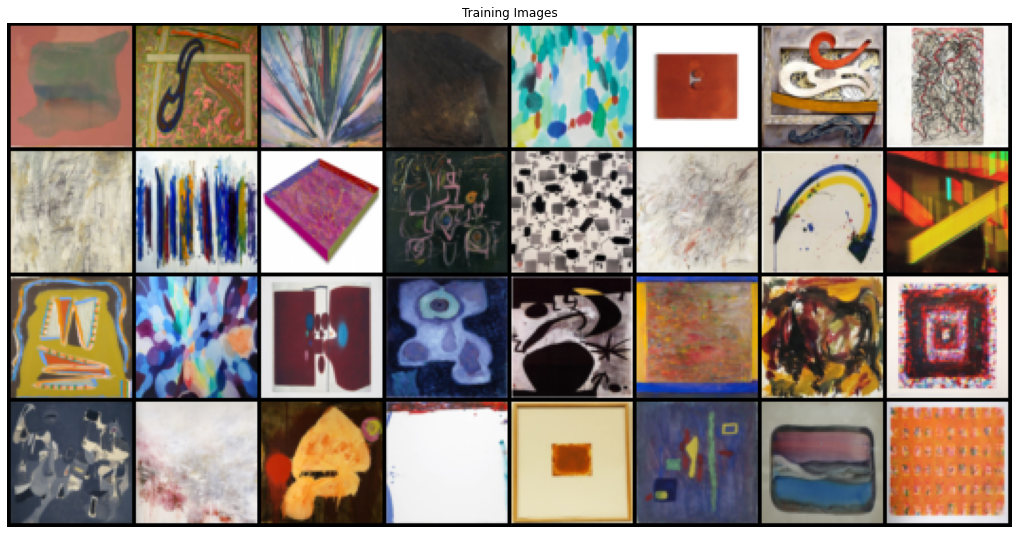

In [ ]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN Generator Architecture

In [ ]:
# custom weights initialization based on the 2015 DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: #find-.-1,3
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)#4*4
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)#8*8
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)#16*16
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)#32*32
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)#64*64

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)


Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


# Discriminator architecture



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)#32*32
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)#16*16
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)#4*4
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)#2*2
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)#1*1[k]

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


In [ ]:
# cross binary entropy
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)#latent space

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# restore to the latest checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

# Training the GAN

In [ ]:
generator_loss = []
discriminator_loss = []
iters = 100
img_list = []

In [ ]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):

        # train the discriminator
        discriminator.zero_grad()
        real_data = data[0].to(device)#image
        real_size = real_data.size(0)#batch

        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)#true label

        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)

        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()

        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)

        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)

        # classify all fake batch with discriminator
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()

        # the sum of the discriminator
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()

        # train the generator
        generator.zero_grad()
        # pretend the generated results are real
        label.fill_(real_label)

        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()

        # print out summary statistics
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))

        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())

         # Check how the generator is doing by saving output on fixed_noise
        if (iters % 500 == 0):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1


  0%|          | 0/90 [00:00<?, ?it/s]

[0/10][0/90]	Loss_D: 0.0795	Loss_G: 5.8660
[0/10][10/90]	Loss_D: 0.0481	Loss_G: 5.8863
[0/10][20/90]	Loss_D: 0.2022	Loss_G: 4.8846
[0/10][30/90]	Loss_D: 0.0548	Loss_G: 6.1385
[0/10][40/90]	Loss_D: 0.0796	Loss_G: 6.8658
[0/10][50/90]	Loss_D: 0.1143	Loss_G: 6.1440
[0/10][60/90]	Loss_D: 0.0530	Loss_G: 6.6270
[0/10][70/90]	Loss_D: 0.0533	Loss_G: 5.6982
[0/10][80/90]	Loss_D: 0.0340	Loss_G: 6.0942


  0%|          | 0/90 [00:00<?, ?it/s]

[1/10][0/90]	Loss_D: 0.1586	Loss_G: 6.1413
[1/10][10/90]	Loss_D: 0.0726	Loss_G: 5.8219
[1/10][20/90]	Loss_D: 0.0956	Loss_G: 5.4816
[1/10][30/90]	Loss_D: 0.0474	Loss_G: 4.9774
[1/10][40/90]	Loss_D: 0.0482	Loss_G: 6.0355
[1/10][50/90]	Loss_D: 0.0633	Loss_G: 5.3051
[1/10][60/90]	Loss_D: 0.0791	Loss_G: 5.4964
[1/10][70/90]	Loss_D: 0.0287	Loss_G: 5.3198
[1/10][80/90]	Loss_D: 0.0618	Loss_G: 5.4427


  0%|          | 0/90 [00:00<?, ?it/s]

[2/10][0/90]	Loss_D: 0.0438	Loss_G: 6.1885
[2/10][10/90]	Loss_D: 0.3559	Loss_G: 5.8056
[2/10][20/90]	Loss_D: 0.3323	Loss_G: 5.5903
[2/10][30/90]	Loss_D: 0.1150	Loss_G: 5.7767
[2/10][40/90]	Loss_D: 0.1762	Loss_G: 7.7178
[2/10][50/90]	Loss_D: 0.1811	Loss_G: 5.2937
[2/10][60/90]	Loss_D: 0.1813	Loss_G: 4.7937
[2/10][70/90]	Loss_D: 0.0661	Loss_G: 5.6308
[2/10][80/90]	Loss_D: 0.0919	Loss_G: 6.0636


  0%|          | 0/90 [00:00<?, ?it/s]

[3/10][0/90]	Loss_D: 0.1197	Loss_G: 7.9111
[3/10][10/90]	Loss_D: 0.1634	Loss_G: 4.4022
[3/10][20/90]	Loss_D: 0.1470	Loss_G: 6.4657
[3/10][30/90]	Loss_D: 0.0752	Loss_G: 5.7255
[3/10][40/90]	Loss_D: 0.1713	Loss_G: 5.8567
[3/10][50/90]	Loss_D: 0.0413	Loss_G: 6.0814
[3/10][60/90]	Loss_D: 0.1171	Loss_G: 5.4928
[3/10][70/90]	Loss_D: 0.3096	Loss_G: 6.6899
[3/10][80/90]	Loss_D: 0.1232	Loss_G: 4.9312


  0%|          | 0/90 [00:00<?, ?it/s]

[4/10][0/90]	Loss_D: 0.1402	Loss_G: 6.1813
[4/10][10/90]	Loss_D: 0.0700	Loss_G: 4.7768
[4/10][20/90]	Loss_D: 0.0466	Loss_G: 6.0326
[4/10][30/90]	Loss_D: 0.0600	Loss_G: 5.1951
[4/10][40/90]	Loss_D: 0.0574	Loss_G: 5.6836
[4/10][50/90]	Loss_D: 0.0154	Loss_G: 5.5719
[4/10][60/90]	Loss_D: 0.0873	Loss_G: 5.1571
[4/10][70/90]	Loss_D: 0.0433	Loss_G: 5.8859
[4/10][80/90]	Loss_D: 0.0452	Loss_G: 5.8757


  0%|          | 0/90 [00:00<?, ?it/s]

[5/10][0/90]	Loss_D: 0.2433	Loss_G: 5.5441
[5/10][10/90]	Loss_D: 0.0338	Loss_G: 5.7894
[5/10][20/90]	Loss_D: 0.0929	Loss_G: 5.2887
[5/10][30/90]	Loss_D: 0.1237	Loss_G: 4.5753
[5/10][40/90]	Loss_D: 0.1172	Loss_G: 5.9888
[5/10][50/90]	Loss_D: 0.1372	Loss_G: 4.6724
[5/10][60/90]	Loss_D: 0.0438	Loss_G: 6.8320
[5/10][70/90]	Loss_D: 0.0763	Loss_G: 5.5985
[5/10][80/90]	Loss_D: 0.1473	Loss_G: 6.2489


  0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a802d00eb90>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a802d00eb90>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():    
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():
      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can o

[6/10][0/90]	Loss_D: 0.1099	Loss_G: 6.5788
[6/10][10/90]	Loss_D: 0.0321	Loss_G: 6.6542
[6/10][20/90]	Loss_D: 0.0278	Loss_G: 5.9163
[6/10][30/90]	Loss_D: 0.0381	Loss_G: 6.4385
[6/10][40/90]	Loss_D: 0.0278	Loss_G: 6.7884
[6/10][50/90]	Loss_D: 0.0315	Loss_G: 5.0029
[6/10][60/90]	Loss_D: 0.0312	Loss_G: 6.0505
[6/10][70/90]	Loss_D: 0.0603	Loss_G: 5.3891
[6/10][80/90]	Loss_D: 0.1440	Loss_G: 3.7568


  0%|          | 0/90 [00:00<?, ?it/s]

[7/10][0/90]	Loss_D: 0.0304	Loss_G: 5.7111
[7/10][10/90]	Loss_D: 0.0238	Loss_G: 6.4943
[7/10][20/90]	Loss_D: 0.1740	Loss_G: 3.4258
[7/10][30/90]	Loss_D: 0.0864	Loss_G: 5.6724
[7/10][40/90]	Loss_D: 0.0193	Loss_G: 6.1066
[7/10][50/90]	Loss_D: 0.0121	Loss_G: 7.1564
[7/10][60/90]	Loss_D: 0.0531	Loss_G: 5.8993
[7/10][70/90]	Loss_D: 0.0334	Loss_G: 6.8377
[7/10][80/90]	Loss_D: 0.0559	Loss_G: 5.3511


  0%|          | 0/90 [00:00<?, ?it/s]

[8/10][0/90]	Loss_D: 0.0907	Loss_G: 5.8222
[8/10][10/90]	Loss_D: 0.2853	Loss_G: 9.9690
[8/10][20/90]	Loss_D: 0.0930	Loss_G: 8.0725
[8/10][30/90]	Loss_D: 0.1085	Loss_G: 7.0318
[8/10][40/90]	Loss_D: 0.0698	Loss_G: 6.0722
[8/10][50/90]	Loss_D: 0.0949	Loss_G: 4.9277
[8/10][60/90]	Loss_D: 0.0342	Loss_G: 6.1689
[8/10][70/90]	Loss_D: 0.0501	Loss_G: 6.1204
[8/10][80/90]	Loss_D: 0.0245	Loss_G: 5.5554


  0%|          | 0/90 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a802d00eb90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a802d00eb90>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

[9/10][0/90]	Loss_D: 0.3430	Loss_G: 11.8464
[9/10][10/90]	Loss_D: 0.0414	Loss_G: 6.7759
[9/10][20/90]	Loss_D: 0.1427	Loss_G: 6.0027
[9/10][30/90]	Loss_D: 0.0661	Loss_G: 6.2020
[9/10][40/90]	Loss_D: 0.0990	Loss_G: 5.5760
[9/10][50/90]	Loss_D: 0.0666	Loss_G: 6.3557
[9/10][60/90]	Loss_D: 0.0513	Loss_G: 6.2075
[9/10][70/90]	Loss_D: 0.0194	Loss_G: 6.4232
[9/10][80/90]	Loss_D: 0.1055	Loss_G: 6.5054


# Training statistics

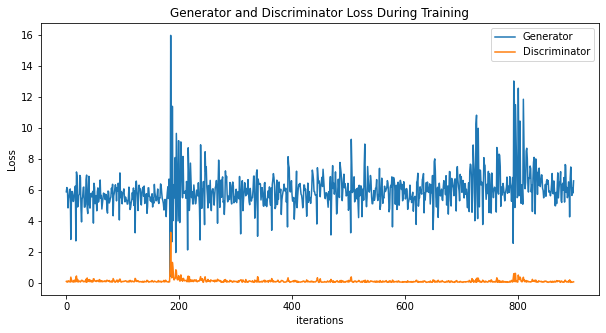

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# GIF visualization

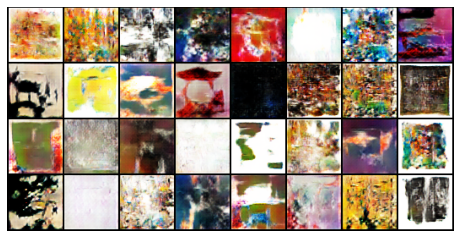

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Save model

In [ ]:
end_epoch = epoch_restore + epochs
save_file = "{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)